
# Clustering

Importing the Libraries

In [ ]:
import pandas as pd
import numpy as np
import csv
from scipy.sparse import csr_matrix
import sklearn.metrics as metrics
import sklearn.datasets as sk_data
from google.colab import drive
from sklearn.datasets import make_blobs
import sklearn.feature_extraction.text as sk_text
import sklearn.cluster as sk_cluster
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing and setting up the dataframes

In [ ]:
from io import StringIO
#import ijson
number_of_lines = 10000
json_lines = []
user = pd.DataFrame()

f =  open('/content/gdrive/MyDrive/yelp_academic_dataset_review.json' , 'r')

while True:
    
  for i in range(number_of_lines):
        
    line = f.readline()
    json_lines.append(line)

  json_str = ''.join(json_lines)
  temp = pd.read_json(StringIO(json_str), encoding = 'utf8', lines=True) 

  if len(temp) == 0 :
    break
  #print(type(temp))
  print(temp)
  user = user.append(temp)
  json_lines.clear()

print(len(user))
#user.head()

In [ ]:
business = pd.read_json('/content/gdrive/MyDrive/small/yelp_academic_dataset_business.json',encoding = 'utf8', lines=True) 

dataToronto_bus = business.loc[business['city'] == 'Phoenix']

dataToronto3 = dataToronto_bus.loc[dataToronto_bus['review_count'] >= 10]

selection = ['Beauty & Spas', 'Shopping' ,'Bars']
dataToronto3 = dataToronto3[pd.DataFrame(dataToronto3.categories.tolist()).isin(selection).any(1).values]

In [ ]:
user = pd.read_json('/content/gdrive/MyDrive/small/yelp_academic_dataset_review.json',encoding = 'utf8', lines=True) 
user.head()

,votes,user_id,review_id,stars,date,text,type,business_id
0,"{'funny': 0, 'useful': 5, 'cool': 2}",rLtl8ZkDX5vH5nAx9C3q5Q,fWKvX83p0-ka4JS3dc6E5A,5,2011-01-26,My wife took me here on my birthday for breakf...,review,9yKzy9PApeiPPOUJEtnvkg
1,"{'funny': 0, 'useful': 0, 'cool': 0}",0a2KyEL0d3Yb1V6aivbIuQ,IjZ33sJrzXqU-0X6U8NwyA,5,2011-07-27,I have no idea why some people give bad review...,review,ZRJwVLyzEJq1VAihDhYiow
2,"{'funny': 0, 'useful': 1, 'cool': 0}",0hT2KtfLiobPvh6cDC8JQg,IESLBzqUCLdSzSqm0eCSxQ,4,2012-06-14,love the gyro plate. Rice is so good and I als...,review,6oRAC4uyJCsJl1X0WZpVSA
3,"{'funny': 0, 'useful': 2, 'cool': 1}",uZetl9T0NcROGOyFfughhg,G-WvGaISbqqaMHlNnByodA,5,2010-05-27,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,_1QQZuf4zZOyFCvXc0o6Vg
4,"{'funny': 0, 'useful': 0, 'cool': 0}",vYmM4KTsC8ZfQBg-j5MWkw,1uJFq2r5QfJG_6ExMRCaGw,5,2012-01-05,General Manager Scott Petello is a good egg!!!...,review,6ozycU1RpktNG2-1BroVtw


In [ ]:
dataToronto3.head()

## Organize the data - preprocessing



The code below creates a corpus. For every business I collect the text reviews from every user as a list of strings -where every element is the entire review text for that perticular business.

The list will keep a series of numbers [0,1,2], where every number represents a cluster - category.

1.   "0" : BARS
2.   "1" : BEAUTY AND SPAS
3.   "2" : SHOPPING

I will use this list to calculate the confusion matrix.

In [ ]:
filenames = []
true_labels = []

for index,row in dataToronto3.iterrows(): 

  bus_data = user.loc[user['business_id'] == row[0]]
  review_texts = pd.DataFrame(columns = ['texts'])
  review_texts['texts'] = bus_data['text']
  filename = row[7] 

  if "/" in filename:
    filename = filename.replace('/', '|')

  if "Bars" in row[4]: 
    true_labels.append(0)

  elif "Beauty & Spas" in row[4]:
    true_labels.append(1)

  elif "Shopping" in row[4]:
    true_labels.append(2)

  review_texts.to_csv(filename,index=False,header=False)
  filenames.append(filename)    
  

Walgreens
Williams-Sonoma
Armadillo Grill
The Roosevelt
Berridge Nurseries
The Home Depot
Bashas
Party City of Paradise Valley
Arcadia Tavern
The Bee's Knees
Bliss ReBAR
Half Moon Sports Grill
Barfly
Vien Nails & Spa
Gallagher's
Pro Nails by Tina
Gentleman Joe's Barber Shop
Capri Nails
Park Central Mall
Target
Le Le Nails
Islands Restaurant
Target Stores
Paperjoy
Costco
Tim Finnegan's Irish Restaurant and Pub
Zipps Sports Grill
The Duce
Padre's Modern Mexican Cuisine
Community Florist
Clarendon Kitchen + Bar C4
The Paper Heart Gallery
Walmart
Copenhagen Imports
Above and Beyond Nails
Astor House
Bar Bianco
Homme
Carly's Bistro
Sports Authority
The Ruby Room
Saks Fifth Avenue
Ulta Salon Cosmetics & Fragrance
Queen Nails & Spa
Bed Bath & Beyond
MADE Art Boutique
Bunky Boutique
Desert Ridge Marketplace
Fry's Food & Drug Stores & Fry's Marketplace
The Icehouse
DH La Nails
Connolly's Sports Grill
The Turf
Bailey's Pub
Delux
Dick's Sporting Goods
Go-Kat-Go
Central Phoenix Eye Care
Revive Spa

In [ ]:
true_labels = np.array(true_labels)

print(true_labels)

[1 2 0 0 2 2 2 2 0 2 0 0 0 1 0 1 1 1 2 2 1 0 2 2 2 0 0 0 0 2 0 0 2 2 1 0 0
 0 0 2 0 2 1 1 2 2 2 2 2 2 1 0 0 0 0 2 2 2 1 0 0 2 2 0 2 0 0 0 0 2 0 2 1 0
 2 2 0 1 2 0 1 2 1 0 0 1 0 2 2 2 2 2 0 2 1 2 2 1 1 2 2 2 1 0 1 1 0 2 2 0 2
 2 2 2 0 2 0 2 2 2 2 0 0 0 0 0 2 2 2 2 2 2 0 2 2 2 0 2 2 2 0 0 1 2 0 2 0 0
 2 2 2 2 0 0 1 2 1 2 1 2 2 2 2 0 0 2 2 0 2 2 0 2 0 0 0 0 2 2 1 0 0 2 0 0 2
 2 0 0 1 2 2 1 2 0 0 1 1 0 2 2 0 0 0 0 0 0 2 2 0 0 2 1 0 2 2 0 0 1 1 0 1 2
 1 2 2 0 2 2 2 0 2 0 2 1 2 2 2 0 0 0 2 1 2 2 2 0 1 0 1 2 0 0 1 2 0 0 0 2 0
 2 2 2 2 2 0 0 0 2 0 2 2 0 1 0 0 2 0 2 0 0 1 0 1 0 0 0 0 2 2 1 1 2 1 0 2 0
 0 1 0 2 0 2 0 2 2 0 1 0 2 2 1 0 2 1 0 0 0 1 2 0 1 2 2 2 2 0 0 0 0 2 2 0 2
 0 2 0 0 0 0 2 0 2 2 0 0 0 2 2 2 1 0 2 0 2 0 2 1 2 2 2 2 2 1 0 2 2 2 0 2 2
 1 2 0 2 1 2 0 0 0 2 2 2 1 2 0 1 0 2 0 0 1 0 1 2 1 0 0 0 2 0 0 2 1 2 1 0 1
 0 0 0 0 2 2 2 2 2 2 0 0 0 2 0 2 2 1 0 0 2 2 1 1 2 2]



Implementation of corpus, whixh is a list where every element is all of the test reviews of that specific business.

In [ ]:
corpus = []
temp_doc = []
for fil in filenames:
  with open(fil, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)

    for line in csv_reader: 
      
      temp_str = ''.join(line)
      temp_doc.append(temp_str)

  doc_string = ''.join(temp_doc)
  corpus.append(doc_string)
  temp_doc.clear()

print(len(corpus))
            

433


tf-idf representation of the businesses.

In [ ]:
vectorizer = sk_text.TfidfVectorizer(stop_words = 'english', min_df=10)
X = vectorizer.fit_transform(corpus)
print(X.toarray())
print (vectorizer.get_feature_names())

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01215763 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
['00', '000', '00pm', '07', '08', '09', '10', '100', '1000', '101', '10am', '10pm', '11', '110', '115', '11am', '11pm', '12', '120', '13', '14', '15', '150', '16', '16th', '17', '18', '180', '19', '19th', '1am', '1pm', '1st', '20', '200', '2000', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '21', '21st', '22', '23', '24', '25', '26', '27', '28', '29', '2am', '2nd', '2pm', '2x', '30', '300', '30am', '30pm', '30s', '31', '32', '35', '36', '39', '3pm', '3rd', '40', '400', '40s', '42', '45', '48', '49', '4pm', '4th', '50', '500', '55', '5pm', 

# 1.

k-means

In [ ]:
kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_
error = kmeans.inertia_
print ("The total error of the clustering is: ", error)
print ('\nCluster labels')
print(kmeans_labels)
print ('\n Cluster Centroids')
print (centroids)


The total error of the clustering is:  274.77760216261953

Cluster labels
[2 2 0 0 1 2 2 1 0 2 0 0 0 1 0 1 1 1 1 1 1 0 2 2 1 0 0 0 0 2 0 1 1 2 1 0 0
 0 0 2 0 2 1 1 2 2 2 2 2 1 1 1 0 0 0 2 2 1 1 1 0 1 1 0 2 0 1 0 1 1 1 2 1 0
 2 2 0 1 2 0 1 2 1 0 0 1 1 1 2 2 1 2 0 2 1 1 1 1 1 2 1 2 1 1 1 1 0 2 2 0 1
 2 2 2 1 2 0 1 2 2 2 1 0 0 0 0 1 1 2 2 1 2 1 2 2 1 0 2 2 2 1 0 1 2 1 1 0 0
 2 1 2 1 0 0 1 2 1 2 1 2 2 2 1 0 0 2 2 0 1 2 1 2 0 0 0 0 2 1 1 0 1 2 0 1 1
 2 0 0 1 2 2 1 1 0 0 1 1 1 2 1 0 0 0 0 0 0 1 2 0 0 2 1 0 1 2 0 0 1 1 0 1 2
 1 2 2 0 2 2 2 0 2 0 2 1 1 1 2 0 0 1 2 1 1 2 2 0 1 0 1 2 0 0 1 2 1 1 0 1 0
 1 2 2 2 2 0 0 0 1 0 2 2 0 1 0 1 2 0 2 1 0 2 0 1 0 0 0 0 1 2 1 1 1 1 0 2 1
 0 1 0 1 0 2 0 2 2 0 1 1 1 2 1 0 1 1 0 1 0 0 2 1 1 2 1 2 1 1 0 0 0 2 2 0 2
 0 2 0 0 0 0 1 1 2 2 0 0 0 1 2 2 2 0 1 0 1 0 1 1 2 2 1 1 1 0 0 2 1 2 0 1 2
 1 2 0 2 1 1 1 0 0 2 2 2 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 2 1 2 1 0 1
 0 0 0 1 2 2 2 1 1 1 0 0 0 2 0 2 2 0 0 0 1 2 1 1 2 2]

 Cluster Centroids
[[0.00513702 0.00112225 0.0

The most frequent terms per cluster.

In [ ]:
k=3
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
  print ("Cluster %d:" % i)
  for ind in order_centroids[i, :10]:
    print (' %s' % terms[ind])
  print


Top terms per cluster:
Cluster 0:
 bar
 food
 place
 good
 great
 like
 just
 drinks
 night
 really
Cluster 1:
 pedicure
 nails
 massage
 place
 nail
 pedi
 salon
 great
 time
 like
Cluster 2:
 store
 like
 place
 just
 great
 items
 shop
 really
 love
 don


In [ ]:
C1= metrics.confusion_matrix(kmeans_labels,true_labels)
print (C1)

[[141   3   0]
 [ 31  63  65]
 [  0   3 127]]


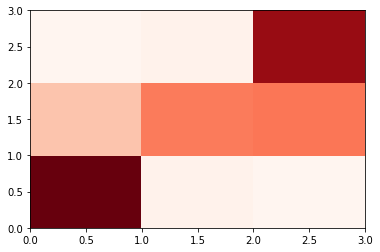

In [ ]:
plt.pcolormesh(C1,cmap=plt.cm.Reds)

In [ ]:
p = metrics.precision_score(true_labels,kmeans_labels, average=None)
print(p)
r = metrics.recall_score(true_labels,kmeans_labels, average = None)
print(r)

[0.20143885 0.02040816 0.97278912]
[0.1627907  0.04347826 0.74479167]


In [ ]:
def cluster_class_mapping(kmeans_labels,true_labels):
  C= metrics.confusion_matrix(kmeans_labels,true_labels)
  mapping = list(np.argmax(C,axis=1)) #for each row (cluster) find the best␣,→class in the confusion matrix
  mapped_kmeans_labels = [mapping[l] for l in kmeans_labels]
  C2= metrics.confusion_matrix(mapped_kmeans_labels,true_labels)
  return mapped_kmeans_labels,C2

mapped_kmeans_labels,C = cluster_class_mapping(kmeans_labels, true_labels)
print(C)


[[144   3   0]
 [ 28  62  49]
 [  0   4 143]]


In [ ]:
agglo = sk_cluster.AgglomerativeClustering(linkage = 'complete', n_clusters = 3)
agglo_labels = agglo.fit_predict(X.toarray())
C_agglo= metrics.confusion_matrix(agglo_labels,true_labels)
print (C_agglo)


mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
print(C_agglo)
p = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print(p)
r = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print(r)

[[172  29  57]
 [  0  36   2]
 [  0   4 133]]
[[172  29  57]
 [  0  36   2]
 [  0   4 133]]
0.846256924487852
0.7875288683602771


In [ ]:
agglo = sk_cluster.AgglomerativeClustering(linkage = 'average', n_clusters = 3)
agglo_labels = agglo.fit_predict(X.toarray())
C_agglo= metrics.confusion_matrix(agglo_labels,true_labels)
print (C_agglo)


mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
print(C_agglo)
p = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print(p)
r = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print(r)

[[172  68 191]
 [  0   1   0]
 [  0   0   1]]
[[  0   0   0]
 [  0   1   0]
 [172  68 192]]
0.3564280215550423
0.4457274826789838


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
agglo = sk_cluster.AgglomerativeClustering(linkage = 'single', n_clusters = 3)
agglo_labels = agglo.fit_predict(X.toarray())
C_agglo= metrics.confusion_matrix(agglo_labels,true_labels)
print (C_agglo)


mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
print(C_agglo)
p = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print(p)
r = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print(r)

[[172  69 190]
 [  0   0   1]
 [  0   0   1]]
[[  0   0   0]
 [  0   0   0]
 [172  69 192]]
0.19661953501272075
0.44341801385681295


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
agglo = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 3)
agglo_labels = agglo.fit_predict(X.toarray())
C_agglo= metrics.confusion_matrix(agglo_labels,true_labels)
print (C_agglo)


mapped_agglo_labels,C_agglo = cluster_class_mapping(agglo_labels,true_labels)
print(C_agglo)
p = metrics.precision_score(true_labels,mapped_agglo_labels, average='weighted')
print(p)
r = metrics.recall_score(true_labels,mapped_agglo_labels, average = 'weighted')
print(r)

[[ 34  45 190]
 [138   0   2]
 [  0  24   0]]
[[138   0   2]
 [  0  24   0]
 [ 34  45 190]]
0.8641021709988116
0.812933025404157


# 2.

Sihlouette score and plot

Text(0, 0.5, 'Error')

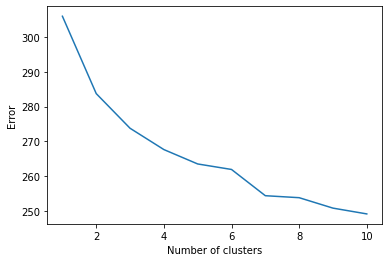

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

error = np.zeros(11) # change
sh_score = np.zeros(11) # change

for k in range(1,11):
  kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=k, n_init=10)
  kmeans.fit_predict(X)
  error[k] = kmeans.inertia_
  if k>1: sh_score[k]= metrics.silhouette_score(X, kmeans.labels_)

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

Text(0, 0.5, 'silhouette score')

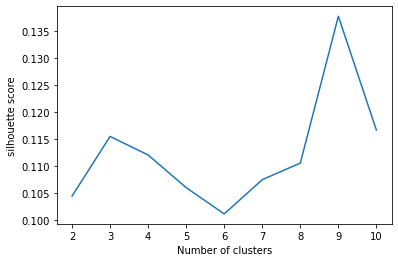

In [ ]:
plt.plot(range(2,len(sh_score)),sh_score[2:])
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')


The peaks of the graph indicates that the most preferable k nalues are 3 and 9, so i will use the k-means algorithm again for k=9 (n_clusters).

In [ ]:
kmeans = sk_cluster.KMeans(init='k-means++', n_clusters=9, n_init=10)
kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_
error = kmeans.inertia_
print ("The total error of the clustering is: ", error)
print ('\nCluster labels')
print(kmeans_labels)
print ('\n Cluster Centroids')
print (centroids)


The total error of the clustering is:  250.95784728801823

Cluster labels
[0 0 6 2 0 0 0 0 6 0 6 6 6 3 6 3 0 3 4 1 3 6 0 0 1 6 6 6 6 0 6 2 1 0 3 5 2
 8 6 7 2 0 1 3 7 0 0 4 0 1 3 1 6 8 6 7 0 1 1 1 6 1 1 6 0 2 1 2 1 1 1 0 0 8
 0 0 2 3 0 6 3 7 0 2 5 1 1 1 0 0 0 0 8 4 3 1 5 1 1 7 1 0 3 2 1 3 6 0 0 6 1
 0 0 0 1 0 6 1 0 0 0 1 6 5 6 5 4 5 0 0 7 0 1 0 0 1 6 0 4 0 1 5 1 0 8 1 2 6
 0 1 0 1 6 6 3 0 1 0 0 7 0 0 0 2 5 0 7 2 4 0 1 0 6 6 6 8 0 0 0 6 1 0 2 1 0
 0 2 6 0 0 0 3 1 6 2 1 1 1 0 1 2 5 6 5 2 6 0 0 2 2 0 0 6 1 0 6 6 0 3 6 1 0
 1 0 0 2 0 0 0 5 0 5 4 3 1 0 0 8 6 1 0 3 1 0 0 5 1 5 1 0 6 2 3 0 1 1 8 0 6
 1 0 0 7 4 2 8 8 1 6 7 0 2 1 8 1 0 6 0 1 2 0 8 3 6 6 5 5 1 0 0 3 1 3 5 0 1
 2 3 5 1 6 0 2 0 0 2 7 1 1 0 1 8 1 3 6 1 6 5 0 1 3 0 0 7 1 1 6 6 6 0 0 6 0
 6 0 2 8 6 5 1 1 0 0 5 6 6 1 4 0 4 5 1 6 0 6 0 3 0 0 2 0 1 5 6 0 1 0 6 1 0
 3 0 2 0 3 1 1 5 6 7 0 0 3 1 5 3 6 1 2 5 1 0 3 1 1 1 6 2 0 6 8 0 3 0 3 6 3
 5 8 2 1 0 0 0 0 0 0 8 6 5 7 5 0 0 2 2 2 1 0 3 3 0 0]

 Cluster Centroids
[[6.60913273e-03 3.71238982



For k=9 the total error of the clustering is 250.95784728801823, which is smaller than the one with k=3, 274.6735793674228.
It looks like the slgorithm makes better predictions for a larger number of clusters, even though there is a chance of "overfitting"

In [ ]:
C= metrics.confusion_matrix(kmeans_labels, true_labels)
print (C)

[[  1  11 126   0   0   0   0   0   0]
 [ 28  18  41   0   0   0   0   0   0]
 [ 34   1   1   0   0   0   0   0   0]
 [  0  35   0   0   0   0   0   0   0]
 [  0   1   9   0   0   0   0   0   0]
 [ 25   2   2   0   0   0   0   0   0]
 [ 67   0   0   0   0   0   0   0   0]
 [  0   1  13   0   0   0   0   0   0]
 [ 17   0   0   0   0   0   0   0   0]]


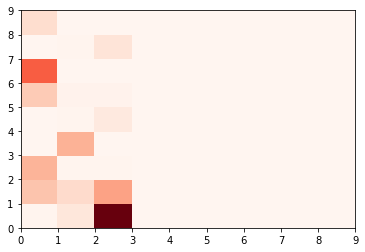

In [ ]:
plt.pcolormesh(C,cmap=plt.cm.Reds)
